In [1]:
import torch
import sbi.utils as utils
from sbi.inference.base import infer

import subprocess

import numpy as np
from matplotlib import pyplot as plt

import corner

from astropy import units as u
from astropy import constants as const

import fileinput

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

import sys, os, glob

import time


/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Toy example of SBI - SAM

 https://sbi-dev.github.io/sbi/install/

 https://astroautomata.com/blog/simulation-based-inference/

 SAM-MCMC: https://arxiv.org/pdf/0810.2548.pdf

 Absolutely read this: https://www.pnas.org/doi/full/10.1073/pnas.1912789117

Benefits over likelihod based:

- self-consistency of simulated observed data. Observed MBHF, bulge relation, LFs are often from different papers with different observational biases. Hence, the observations are not guaranteed to be self-consistent.

- speed / scalability: use deep NN to efficiently learn mapping from inputs to observations, does not suffer from increasing dimensionality adding more terms to the likelihood 

- Flexibility: Any observational quantity can be be added to the model 

Constraining black hole assembly history in semi-analytic models using simulation-based inference 

In [2]:
import torch
import sbi.utils as utils
from sbi.inference.base import infer

from joblib.externals.loky import set_loky_pickler
set_loky_pickler("dill")

Priors

In [3]:
prior = utils.BoxUniform(
    low=torch.tensor([-2, -4, -4, -4]),
    high=torch.tensor([2, 2, 0, 0]),
)

In [4]:
def stellarmassbin( sample, data, lowmass, highmass):

    # This function calculates what we need for specified mass bin
    print( 'Breaking down data into stellar mass bin %s to %s' % (lowmass, highmass) )
    gal = param_dicts(sample, data)
    gal = gal.loc[ ( ( gal.logTSM <= highmass ) & \
        ( lowmass < gal.logTSM ) ) ]
    
    return gal


#### #### #### #### #### #### this is when using halo mass bins
def halomassbin( sample, data, lowmass, highmass):

    # This function calculates what we need for specified mass bin
    print( 'Breaking down data into halo mass bins %s to %s' % (lowmass, highmass) )
    gal = param_dicts(sample, data)
    gal = gal.loc[ ( ( gal.logMvir <= highmass ) & ( lowmass < gal.logMvir ) ) ]
    
    return gal

### SBI Inference

In [8]:

def simulator(theta, darksagepath='/Users/colinburke/research/DarkSage', parfilename='millennium.par',
              fpre='model_z0.000', rmdir=True, maxgals=8000):
    import os
    import glob
    import shutil
    import fileinput
    import subprocess
    import numpy as np
    import torch
    import analysis_darksage as ds
    from astropy import units as u
    from astropy import constants as const

    import corner
    from matplotlib import pyplot as plt

    # Temp
    import random
    i = random.randint(0, 99999999)
    print(i)

    # Generate samples from N(mu, sigma=0.5)
    # Run DARK SAGE with parameters theta
    n, log_kappa_R, log_kappa_Q, log_f_BH = theta
    kappa_R = 10**log_kappa_R
    kappa_Q = 10**log_kappa_Q
    f_BH = 10**log_f_BH

    print('PARS IN:', n, kappa_R, kappa_Q, f_BH)

    # Filepath to the new input directory
    parfilepath = os.path.join(darksagepath, f'input_{i}', parfilename)

    # Make new input directory
    if not os.path.exists(os.path.join(darksagepath, f'input_{i}')):
        os.makedirs(os.path.join(darksagepath, f'input_{i}'))

    # Make new output directory
    indir = os.path.join(darksagepath, f'output_{i}/')
    if not os.path.exists(indir):
        os.makedirs(indir)

    # Copy the input to a new parameter file
    print('Copying from....', os.path.join(darksagepath, f'input', parfilename))
    print('Copying to....', parfilepath)
    shutil.copy(os.path.join(darksagepath, f'input', parfilename), parfilepath)

    # Modify the new parameter file with theta
    with fileinput.input(parfilepath, inplace=True) as file:
        for line in file:
            line = line.replace('\n','')
            if 'OutputDir' in line:
                print(f'OutputDir {indir}')
            # Parameters to vary
            elif 'SeedPowerLawIndex' in line:
                print(f'SeedPowerLawIndex {n}')
            elif 'RadioModeEfficiency' in line:
                print(f'RadioModeEfficiency {kappa_R}')
            elif 'QuasarModeEfficiency' in line:
                print(f'QuasarModeEfficiency {kappa_Q}')
            elif 'BlackHoleGrowthRate' in line:
                print(f'BlackHoleGrowthRate {f_BH}')
            else:
                print(line)

    os.chdir(darksagepath) # Darksage can't find the extra files without this ...sigh...
    print('Running DarkSage with parfile:', parfilepath)
    subprocess.run([f"{darksagepath}/darksage", f"{parfilepath}"])  # Run dark sage w/ theta arguments

    """
    field = [ 'Galaxy_Classification', 'GalaxyIndex', 'HaloIndex', 'Pos', 'Vel', 
        'halospin', 'Mvir', 'Rvir', 'Vvir', 'Vmax', 'Central_Galaxy_Mvir', 
        'VelDisp', 'DiscRadii', 'Cold_Gas_Mass', 'Total_Stellar_Mass', 
        'Mergerdriven_Bulge_Mass', 'Instabilitydriven_Bulge_Mass', 'Hot_Gas_Mass', 
        'Ejected_Gas_Mass', 'Black_Hole_Mass', 'j_Stellar_Disk', 'j_Cold_Gas', 
        'SpinClassicalBulge', 'DiscStars', 'DiscHI', 'DiscH2', 'DiscSFR', 
        'SfrFromH2', 'SfrInstab', 'SfrMergeBurst', 'Disk_Scale_Radius', 
        'Cool_Scale_Radius', 'Cooling', 'Heating', 'Last_Major_Merger', 
        'Last_Minor_Merger', 'OutflowRate', 'Subhalo_Mvir_at_Infall', 
        'Subhalo_Vvir_at_Infall', 'Subhalo_Vmax_at_Infall', 'SnapNum' ]
    """

    field = [ 'Galaxy_Classification', 'GalaxyIndex', 'HaloIndex', 'Pos', 'Vel', 'Mvir', 'Rvir',
    'Vvir', 'Vmax', 'Central_Galaxy_Mvir', 'VelDisp', 'DiscRadii', 'Cold_Gas_Mass', 'Total_Stellar_Mass',
    'Mergerdriven_Bulge_Mass', 'Instabilitydriven_Bulge_Mass', 'Hot_Gas_Mass', 'Ejected_Gas_Mass',
    'Black_Hole_Mass', 'j_Stellar_Disk', 'j_Cold_Gas', 'DiscStars', 'DiscHI',
    'DiscH2', 'DiscSFR', 'SfrFromH2', 'SfrInstab', 'SfrMergeBurst', 'Disk_Scale_Radius', 'Cool_Scale_Radius',
    'Cooling', 'Heating', 'QuasarEnergy', 'BHaccreted', 'BondiBHaccreted', 'RadioBHaccreted', 'QuasarBHaccreted', 'InstaBHaccreted',
    'MergerBHaccreted','RadioBlackHoleMass', 'QuasarBlackHoleMass', 'InstaBlackHoleMass', 'MergerBlackHoleMass',
    'TimeofFirstAccretionRadio', 'TimeofLastAccretionRadio', 'TimeofFirstAccretionQuasar', 'TimeofLastAccretionQuasar',
    'TimeofFirstAccretionInsta', 'TimeofLastAccretionInsta', 'TimeofFirstAccretionMerger', 'TimeofLastAccretionMerger',
    'Last_Major_Merger', 'Last_Minor_Merger', 'OutflowRate', 'Subhalo_Mvir_at_Infall', 'Subhalo_Vvir_at_Infall',
    'Subhalo_Vmax_at_Infall', 'SnapNum' ]


    Nannuli = 30 # number of annuli used for discs in Dark Sage
    sim = 0 # which simulation Dark Sage has been run on -- if it's new, you will need to set its defaults below.
    #   0 = Mini Millennium, 1 = Full Millennium
    #range(512) # list of file numbers you want to read; 
    #change this to range(512) if sim is full Millennium merger tree or range(7) for 50 Mpc box
    files = range(8)


    ##### READ DARK SAGE DATA #####
    data_z0DSage = ds.darksage_snap(indir+fpre, files, fields=field, Nannuli=Nannuli)
    ######  ================= #####

    #massbin = "stellarbin"                                                          # Options: "stellarbin" or "halobin" or " "
    sample = "all"                                                                  # Options: 'all' , 'centrals', 'satellites'
    lowmassbin = 6.0                                                                # lower mass bin for either stellar mass or halo mass
    #highmassbin = 13.0                                                              # higher mass bin for either stellar mass or halo mass

    gal = ds.param_dicts( sample, data_z0DSage )

    gal['logBHL'] = np.log10( (0.1*gal.BHaccreted.to_numpy(dtype=np.float64)*u.Msun/u.yr*const.c**2).to(u.erg/u.s).value)

    # Mask poorly resolved halos or BHs that didn't grow at all
    mask = np.isfinite(gal['logBHM']) & np.isfinite(gal['logBHL'])
    gal = gal[mask]
    print('......................')

    thetahat = np.array([gal['logBHM'], gal['logTSM'], gal['logBHL']])

    print('Number of gals:', len(gal)) # 
    if maxgals > 0:
        print('Reducing to:', len(gal))
        thetahat = thetahat[:,:maxgals].ravel() # Only get first 10k galaxies and flatten
    else:
        thetahat = thetahat.ravel()
    # [MBH, Ms, L]

    # Delete input and output
    if rmdir:
        shutil.rmtree(os.path.join(darksagepath, f'input_{i}'))
        shutil.rmtree(indir)

    #print(thetahat)
    print('shape of output:', thetahat.shape)
    print('............................')
    # [MBH, Ms, L] x N 
    #     
    return torch.from_numpy(thetahat)

Learn the likelihood from the simulator

"RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 1200 but got size 1179 for tensor number 1 in the list."
-- Increase num_sim

In [9]:
num_sim = 20
method = 'SNRE' #SNPE or SNLE or SNRE
posterior = infer(
    simulator,
    prior,
    method=method,
    num_workers=6,
    num_simulations=num_sim)

12613414
56690511
PARS IN: tensor(-0.7327) tensor(0.1974) tensor(0.0059) tensor(0.0056)
Copying from.... /Users/colinburke/research/DarkSage/input/millennium.par
Copying to.... /Users/colinburke/research/DarkSage/input_56690511/millennium.par
Running DarkSage with parfile: /Users/colinburke/research/DarkSage/input_56690511/millennium.par
                   FileNameGalaxies	     model
                          OutputDir	/Users/colinburke/research/DarkSage/output_56690511/
                          FirstFile	         0
                           LastFile	         7
                         NumOutputs	        -1
                           TreeName	 trees_063
                      SimulationDir	/Users/colinburke/research/DarkSage/mini_millennium/treedata
                   FileWithSnapList	/Users/colinburke/research/DarkSage/mini_millennium/millennium.a_list
                     LastSnapShotNr	        63
                              Omega	       0.3
                        OmegaLambda	   

/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/astropy/units/core.py:1073: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _con

Time: 0.701292 s.
Lastly, converting to log form and multiplying by 1e10s...
Time: 0.008754 s.
......................
Number of gals: 26030
Reducing to: 26030
shape of output: (24000,)
............................


Running 20 simulations in 20 batches.:   0%|          | 0/20 [00:00<?, ?it/s]

30991664
41427262
PARS IN: PARS IN: 45734453
59074967
176203
tensor(-1.6631) PARS IN: PARS IN: tensor(-0.2194) tensor(16.2202) tensor(0.0002) tensor(0.0001) PARS IN: tensor(0.0009)
tensor(0.9986) tensor(0.5493)
Copying from.... /Users/colinburke/research/DarkSage/input/millennium.par
Copying to.... /Users/colinburke/research/DarkSage/input_41427262/millennium.par
tensor(1.8778) tensor(-0.6053) Copying from.... /Users/colinburke/research/DarkSage/input/millennium.par
Copying to.... /Users/colinburke/research/DarkSage/input_30991664/millennium.par
tensor(0.0377) tensor(0.0922) tensor(0.1364) tensor(0.3199) tensor(0.0181)
tensor(0.0074)
Copying from.... /Users/colinburke/research/DarkSage/input/millennium.par
Copying to.... /Users/colinburke/research/DarkSage/input_176203/millennium.par
Copying from.... /Users/colinburke/research/DarkSage/input/millennium.par
Copying to.... /Users/colinburke/research/DarkSage/input_59074967/millennium.par
Running DarkSage with parfile: /Users/colinburke/r

/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/astropy/units/core.py:1073: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _con

61502225
PARS IN: tensor(0.0980) tensor(24.7328) tensor(0.0829) tensor(0.0586)
Copying from.... /Users/colinburke/research/DarkSage/input/millennium.par
Copying to.... /Users/colinburke/research/DarkSage/input_61502225/millennium.par
Running DarkSage with parfile: /Users/colinburke/research/DarkSage/input_61502225/millennium.par
                   FileNameGalaxies	     model
                          OutputDir	/Users/colinburke/research/DarkSage/output_61502225/
                          FirstFile	         0
                           LastFile	         7
                         NumOutputs	        -1
                           TreeName	 trees_063
                      SimulationDir	/Users/colinburke/research/DarkSage/mini_millennium/treedata
                   FileWithSnapList	/Users/colinburke/research/DarkSage/mini_millennium/millennium.a_list
                     LastSnapShotNr	        63
                              Omega	       0.3
                        OmegaLambda	       0.7
 

/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/astropy/units/core.py:1073: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _con

shape of output: (24000,)
............................
93335004
PARS IN: tensor(-1.5305) tensor(0.0162) tensor(0.0002) tensor(0.0020)
Copying from.... /Users/colinburke/research/DarkSage/input/millennium.par
Copying to.... /Users/colinburke/research/DarkSage/input_93335004/millennium.par
Running DarkSage with parfile: /Users/colinburke/research/DarkSage/input_93335004/millennium.par
Time taking turning dataset to pandas dataframe: 1.049294 s.
You have chosen a sample of allgalaxies.
Summing up annuli properties...
                   FileNameGalaxies	     model
                          OutputDir	/Users/colinburke/research/DarkSage/output_93335004/
                          FirstFile	         0
                           LastFile	         7
                         NumOutputs	        -1
                           TreeName	 trees_063
                      SimulationDir	/Users/colinburke/research/DarkSage/mini_millennium/treedata
                   FileWithSnapList	/Users/colinburke/resea

/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/astropy/units/core.py:1073: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _con

shape of output: (24000,)
............................
67969104
PARS IN: tensor(0.4702) tensor(0.0110) tensor(0.2659) tensor(0.0277)
Copying from.... /Users/colinburke/research/DarkSage/input/millennium.par
Copying to.... /Users/colinburke/research/DarkSage/input_67969104/millennium.par
Running DarkSage with parfile: /Users/colinburke/research/DarkSage/input_67969104/millennium.par
                   FileNameGalaxies	     model
                          OutputDir	/Users/colinburke/research/DarkSage/output_67969104/
                          FirstFile	         0
                           LastFile	         7
                         NumOutputs	        -1
                           TreeName	 trees_063
                      SimulationDir	/Users/colinburke/research/DarkSage/mini_millennium/treedata
                   FileWithSnapList	/Users/colinburke/research/DarkSage/mini_millennium/millennium.a_list
                     LastSnapShotNr	        63
                              Omega	     

/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/astropy/units/core.py:1073: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _con

Time: 0.686928 s.
Lastly, converting to log form and multiplying by 1e10s...
Time: 0.012653 s.
......................
Number of gals: 19607
Reducing to: 19607
Time: 0.648269 s.
Lastly, converting to log form and multiplying by 1e10s...
Time: 0.015309 s.
......................
Number of gals: 26588
Reducing to: 26588
shape of output: (24000,)
............................


Running 20 simulations in 20 batches.:  25%|██▌       | 5/20 [02:44<04:17, 17.15s/it]

81728482
PARS IN: tensor(-0.1442) tensor(0.0003) tensor(0.0023) tensor(0.6358)
Copying from.... /Users/colinburke/research/DarkSage/input/millennium.par
Copying to.... /Users/colinburke/research/DarkSage/input_81728482/millennium.par
Running DarkSage with parfile: /Users/colinburke/research/DarkSage/input_81728482/millennium.par
shape of output: (24000,)
............................
18098294
PARS IN: tensor(-0.7240) tensor(0.1030) tensor(0.0005) tensor(0.1512)
Copying from.... /Users/colinburke/research/DarkSage/input/millennium.par
Copying to.... /Users/colinburke/research/DarkSage/input_18098294/millennium.par
Running DarkSage with parfile: /Users/colinburke/research/DarkSage/input_18098294/millennium.par
                   FileNameGalaxies	     model
                          OutputDir	/Users/colinburke/research/DarkSage/output_81728482/
                          FirstFile	         0
                           LastFile	         7
                         NumOutputs	        -1
      

/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/astropy/units/core.py:1073: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _con

shape of output: (24000,)
............................
39919005
PARS IN: tensor(0.4076) tensor(0.8359) tensor(0.0057) tensor(0.0010)
Copying from.... /Users/colinburke/research/DarkSage/input/millennium.par
Copying to.... /Users/colinburke/research/DarkSage/input_39919005/millennium.par
Running DarkSage with parfile: /Users/colinburke/research/DarkSage/input_39919005/millennium.par
                   FileNameGalaxies	     model
                          OutputDir	/Users/colinburke/research/DarkSage/output_39919005/
                          FirstFile	         0
                           LastFile	         7
                         NumOutputs	        -1
                           TreeName	 trees_063
                      SimulationDir	/Users/colinburke/research/DarkSage/mini_millennium/treedata
                   FileWithSnapList	/Users/colinburke/research/DarkSage/mini_millennium/millennium.a_list
                     LastSnapShotNr	        63
                              Omega	     

/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/astropy/units/core.py:1073: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _con

Time: 0.732623 s.
Lastly, converting to log form and multiplying by 1e10s...
Time: 0.008393 s.
......................
Number of gals: 9438
Reducing to: 9438
shape of output: (24000,)
............................
61502225
PARS IN: tensor(-0.3136) tensor(0.4597) tensor(0.0055) tensor(0.0001)
Copying from.... /Users/colinburke/research/DarkSage/input/millennium.par
Copying to.... /Users/colinburke/research/DarkSage/input_61502225/millennium.par
Running DarkSage with parfile: /Users/colinburke/research/DarkSage/input_61502225/millennium.par
                   FileNameGalaxies	     model
                          OutputDir	/Users/colinburke/research/DarkSage/output_61502225/
                          FirstFile	         0
                           LastFile	         7
                         NumOutputs	        -1
                           TreeName	 trees_063
                      SimulationDir	/Users/colinburke/research/DarkSage/mini_millennium/treedata
                   FileWithSnapList	

/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/astropy/units/core.py:1073: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _con

Time: 0.704738 s.
Lastly, converting to log form and multiplying by 1e10s...
Time: 0.009892 s.
......................
Number of gals: 9451
Reducing to: 9451
shape of output: (24000,)
............................
87915248
PARS IN: tensor(-0.2937) tensor(0.0005) tensor(0.0008) tensor(0.1021)
Copying from.... /Users/colinburke/research/DarkSage/input/millennium.par
Copying to.... /Users/colinburke/research/DarkSage/input_87915248/millennium.par
Running DarkSage with parfile: /Users/colinburke/research/DarkSage/input_87915248/millennium.par
                   FileNameGalaxies	     model
                          OutputDir	/Users/colinburke/research/DarkSage/output_87915248/
                          FirstFile	         0
                           LastFile	         7
                         NumOutputs	        -1
                           TreeName	 trees_063
                      SimulationDir	/Users/colinburke/research/DarkSage/mini_millennium/treedata
                   FileWithSnapList	

/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/astropy/units/core.py:1073: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _con

shape of output: (24000,)
............................
93913446
PARS IN: tensor(1.9765) tensor(0.1085) tensor(0.0003) tensor(0.0156)
Copying from.... /Users/colinburke/research/DarkSage/input/millennium.par
Copying to.... /Users/colinburke/research/DarkSage/input_93913446/millennium.par
Running DarkSage with parfile: /Users/colinburke/research/DarkSage/input_93913446/millennium.par
Time: 0.705515 s.
Lastly, converting to log form and multiplying by 1e10s...
Time: 0.009120 s.
......................
Number of gals: 27371
Reducing to: 27371


/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/astropy/units/core.py:1073: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _con

shape of output: (24000,)
............................
81153786
PARS IN: tensor(0.4038) tensor(0.0005) tensor(0.0001) tensor(0.0234)
                   FileNameGalaxies	     model
                          OutputDir	/Users/colinburke/research/DarkSage/output_93913446/
                          FirstFile	         0
                           LastFile	         7
                         NumOutputs	        -1
                           TreeName	 trees_063
                      SimulationDir	/Users/colinburke/research/DarkSage/mini_millennium/treedata
                   FileWithSnapList	/Users/colinburke/research/DarkSage/mini_millennium/millennium.a_list
                     LastSnapShotNr	        63
                              Omega	       0.3
                        OmegaLambda	       0.7
                         BaryonFrac	      0.17
                           Hubble_h	       0.7
                           PartMass	 0.0860657
                     SFprescription	         0
           

/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/astropy/units/core.py:1073: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _con

Time: 0.765497 s.
Lastly, converting to log form and multiplying by 1e10s...
Time: 0.008831 s.
......................
Number of gals: 25861
Reducing to: 25861
shape of output: (24000,)
............................
88445375
PARS IN: tensor(-1.3806) tensor(26.5914) tensor(0.2908) tensor(0.0020)
Copying from.... /Users/colinburke/research/DarkSage/input/millennium.par
Copying to.... /Users/colinburke/research/DarkSage/input_88445375/millennium.par
Running DarkSage with parfile: /Users/colinburke/research/DarkSage/input_88445375/millennium.par
                   FileNameGalaxies	     model
                          OutputDir	/Users/colinburke/research/DarkSage/output_88445375/
                          FirstFile	         0
                           LastFile	         7
                         NumOutputs	        -1
                           TreeName	 trees_063
                      SimulationDir	/Users/colinburke/research/DarkSage/mini_millennium/treedata
                   FileWithSnapLi

/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/astropy/units/core.py:1073: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _con

shape of output: (24000,)
............................
78399345
PARS IN: tensor(1.0522) tensor(0.1187) tensor(0.0004) tensor(0.1165)
Copying from.... /Users/colinburke/research/DarkSage/input/millennium.par
Copying to.... /Users/colinburke/research/DarkSage/input_78399345/millennium.par
Running DarkSage with parfile: /Users/colinburke/research/DarkSage/input_78399345/millennium.par
                   FileNameGalaxies	     model
                          OutputDir	/Users/colinburke/research/DarkSage/output_78399345/
                          FirstFile	         0
                           LastFile	         7
                         NumOutputs	        -1
                           TreeName	 trees_063
                      SimulationDir	/Users/colinburke/research/DarkSage/mini_millennium/treedata
                   FileWithSnapList	/Users/colinburke/research/DarkSage/mini_millennium/millennium.a_list
                     LastSnapShotNr	        63
                              Omega	     

/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/astropy/units/core.py:1073: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _con

shape of output: (24000,)
............................
39055448
PARS IN: tensor(-0.1774) tensor(4.5357) tensor(0.0002) tensor(0.0003)
Copying from.... /Users/colinburke/research/DarkSage/input/millennium.par
Copying to.... /Users/colinburke/research/DarkSage/input_39055448/millennium.par
Running DarkSage with parfile: /Users/colinburke/research/DarkSage/input_39055448/millennium.par
                   FileNameGalaxies	     model
                          OutputDir	/Users/colinburke/research/DarkSage/output_39055448/
                          FirstFile	         0
                           LastFile	         7
                         NumOutputs	        -1
                           TreeName	 trees_063
                      SimulationDir	/Users/colinburke/research/DarkSage/mini_millennium/treedata
                   FileWithSnapList	/Users/colinburke/research/DarkSage/mini_millennium/millennium.a_list
                     LastSnapShotNr	        63
                              Omega	    

/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/astropy/units/core.py:1073: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _con

shape of output: (24000,)
............................
35027290
PARS IN: tensor(1.1957) tensor(0.1661) tensor(0.0055) tensor(0.0059)
Copying from.... /Users/colinburke/research/DarkSage/input/millennium.par
Copying to.... /Users/colinburke/research/DarkSage/input_35027290/millennium.par
Running DarkSage with parfile: /Users/colinburke/research/DarkSage/input_35027290/millennium.par
                   FileNameGalaxies	     model
                          OutputDir	/Users/colinburke/research/DarkSage/output_35027290/
                          FirstFile	         0
                           LastFile	         7
                         NumOutputs	        -1
                           TreeName	 trees_063
                      SimulationDir	/Users/colinburke/research/DarkSage/mini_millennium/treedata
                   FileWithSnapList	/Users/colinburke/research/DarkSage/mini_millennium/millennium.a_list
                     LastSnapShotNr	        63
                              Omega	     

/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/astropy/units/core.py:1073: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _con

shape of output: (24000,)
............................

done file 5

	file: 6	tree: 0 of 3119

done file 7

reading file 0
reading file 1
reading file 2
reading file 3
reading file 4
reading file 5
reading file 6
reading file 7
Loading data...

done file 2

	file: 3	tree: 0 of 4928
Time taking turning dataset to pandas dataframe: 1.045553 s.
You have chosen a sample of allgalaxies.
Summing up annuli properties...
Time: 0.704298 s.
Lastly, converting to log form and multiplying by 1e10s...
Time: 0.009031 s.
......................
Number of gals: 28347
Reducing to: 28347


/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/astropy/units/core.py:1073: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _con

shape of output: (24000,)
............................
new high mark = 37.3214 MB
new high mark = 216.994 MB

done file 0

	file: 1	tree: 0 of 2864

done file 5

	file: 6	tree: 0 of 3119

done file 6

	file: 7	tree: 0 of 3426
new high mark = 235.526 MB

done file 1

	file: 2	tree: 0 of 4475

done file 6

	file: 7	tree: 0 of 3426

done file 7

reading file 0
reading file 1
reading file 2
reading file 3
reading file 4
reading file 5
reading file 6
reading file 7
Loading data...
Time taking turning dataset to pandas dataframe: 0.602826 s.
You have chosen a sample of allgalaxies.
Summing up annuli properties...
Time: 0.632254 s.
Lastly, converting to log form and multiplying by 1e10s...
Time: 0.008899 s.
......................
Number of gals: 18389
Reducing to: 18389


/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/astropy/units/core.py:1073: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _con

shape of output: (24000,)
............................

done file 3

	file: 4	tree: 0 of 3508

done file 2

	file: 3	tree: 0 of 4928

done file 7

reading file 0
reading file 1
reading file 2
reading file 3
reading file 4
reading file 5
reading file 6
reading file 7
Loading data...
Time taking turning dataset to pandas dataframe: 0.709149 s.
You have chosen a sample of allgalaxies.
Summing up annuli properties...
Time: 0.649187 s.
Lastly, converting to log form and multiplying by 1e10s...
Time: 0.009235 s.
......................
Number of gals: 26635
Reducing to: 26635


/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/astropy/units/core.py:1073: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _con

shape of output: (24000,)
............................

done file 4

	file: 5	tree: 0 of 3833

done file 3

	file: 4	tree: 0 of 3508

done file 5

	file: 6	tree: 0 of 3119

done file 4

	file: 5	tree: 0 of 3833

done file 6

	file: 7	tree: 0 of 3426

done file 5

	file: 6	tree: 0 of 3119

done file 7

reading file 0
reading file 1
reading file 2
reading file 3
reading file 4
reading file 5

done file 6

	file: 7	tree: 0 of 3426
reading file 6
reading file 7
Loading data...
Time taking turning dataset to pandas dataframe: 0.620197 s.
You have chosen a sample of allgalaxies.
Summing up annuli properties...
Time: 0.648114 s.
Lastly, converting to log form and multiplying by 1e10s...
Time: 0.007904 s.
......................
Number of gals: 14530
Reducing to: 14530


/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/astropy/units/core.py:1073: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _con

shape of output: (24000,)
............................

done file 7

reading file 0
reading file 1
reading file 2
reading file 3
reading file 4
reading file 5
reading file 6
reading file 7
Loading data...
Time taking turning dataset to pandas dataframe: 0.592284 s.
You have chosen a sample of allgalaxies.
Summing up annuli properties...


/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/astropy/units/core.py:1073: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _con

Time: 0.598878 s.
Lastly, converting to log form and multiplying by 1e10s...
Time: 0.007731 s.
......................
Number of gals: 9638
Reducing to: 9638
shape of output: (24000,)
............................


 Neural network successfully converged after 24 epochs.

### Generate observed distributions

In [10]:
def GSMF(M_star, size=1, mean=True):
    """
    Galaxy stellar mass function of the z ~ 0 blue+green galaxy population (single Schechter function)
    https://ui.adsabs.harvard.edu/abs/2012MNRAS.421..621B/abstract
    """
    logM_br = 10.78
    dlogM_br = 0.01
    
    phi1 = 2.96*1e-3
    dphi1 = 0.40*1e-3
    
    phi2 = 0.63*1e-3
    dphi2 = 0.10*1e-3
    
    alpha1 = -0.62
    dalpha1 = 0.03
    
    alpha2 = -1.50
    dalpha2 = 0.01

    if mean==False:
    
        M_br = 10**np.random.normal(loc=logM_br, scale=dlogM_br, size=size)*u.Msun
        phi1 = np.random.normal(loc=phi1, scale=dphi1, size=size)*u.Mpc**-3
        
        phi2 = np.random.normal(loc=phi2, scale=dphi2, size=size)*u.Mpc**-3
        
        alpha1 = np.random.normal(loc=alpha1, scale=dalpha1, size=size)
        alpha2 = np.random.normal(loc=alpha2, scale=dalpha2, size=size)

    else:

        M_br = 10**logM_br*u.Msun
        phi1 = phi1*u.Mpc**-3
        
        phi2 = phi2*u.Mpc**-3

    phi = np.exp(-M_star/M_br)/M_br * (phi1*(M_star/M_br)**alpha1 + phi2*(M_star/M_br)**alpha2)

    return phi

In [11]:
def inv_transform_sampling(y, x, n_samples=1000):
    """
    Perform inverse transform sampling on curve y(x)
    https://tmramalho.github.io/blog/2013/12/16/how-to-do-inverse-transformation-sampling-in-scipy-and-numpy/
    https://en.wikipedia.org/wiki/Inverse_transform_sampling
    """
    dx = np.diff(x)
    cum_values = np.zeros(x.shape)
    cum_values[1:] = np.cumsum(y*dx)/np.sum(y*dx)
    r = np.random.rand(int(n_samples))
    return np.interp(r, cum_values, x)

In [12]:
def logGSMF(M_star, size=1):
    """
    Galaxy stellar mass function of the z ~ 0 blue+green galaxy population (single Schechter function)
    https://ui.adsabs.harvard.edu/abs/2012MNRAS.421..621B/abstract
    """
    logM_br = 10.78
    dlogM_br = 0.01
    
    phi1 = 2.96*1e-3
    dphi1 = 0.40*1e-3
    
    phi2 = 0.63*1e-3
    dphi2 = 0.10*1e-3
    
    alpha1 = -0.62
    dalpha1 = 0.03
    
    alpha2 = -1.50
    dalpha2 = 0.01
    
    M_br = 10**np.random.normal(loc=logM_br, scale=dlogM_br, size=size)
    phi1 = np.random.normal(loc=phi1, scale=dphi1, size=size)
    
    phi2 = np.random.normal(loc=phi2, scale=dphi2, size=size)
    
    alpha1 = np.random.normal(loc=alpha1, scale=dalpha1, size=size)
    alpha2 = np.random.normal(loc=alpha2, scale=dalpha2, size=size)

    # dN/dlogM
    phi = np.log(10) * np.exp(-M_star/M_br) * (phi1*(M_star/M_br)**(alpha1+1) + phi2*(M_star/M_br)**(alpha2+1))
    
    return phi

In [13]:
def logGSMF_blue(M_star):
    """
    Galaxy stellar mass function of the z ~ 0 blue+green galaxy population (single Schechter function)
    https://ui.adsabs.harvard.edu/abs/2012MNRAS.421..621B/abstract
    """
    M_br = 10**10.72
    phi = 0.71*1e-3
    alpha = -1.45
    phi = np.log(10) * np.exp(-M_star/M_br) * phi*(M_star/M_br)**(alpha+1)
    return phi

def logGSMF_red(M_star):
    """
    Galaxy stellar mass function of the z ~ 0 red galaxy population (double Schechter function)
    https://ui.adsabs.harvard.edu/abs/2012MNRAS.421..621B/abstract
    """
    M_br = 10**10.72
    phi1 = 3.25*1e-3
    phi2 = 0.08*1e-3
    alpha1 = -0.45
    alpha2 = -1.45
    phi_red = np.log(10) * np.exp(-M_star/M_br) * (phi1*(M_star/M_br)**(alpha1+1) + phi2*(M_star/M_br)**(alpha2+1))

    M_br = 10**10.72
    phi = 0.71*1e-3
    alpha = -1.45
    phi_blue = np.log(10) * np.exp(-M_star/M_br) * phi*(M_star/M_br)**(alpha+1)

    ratio = phi_red / (phi_red + phi_blue)
    
    return phi_red

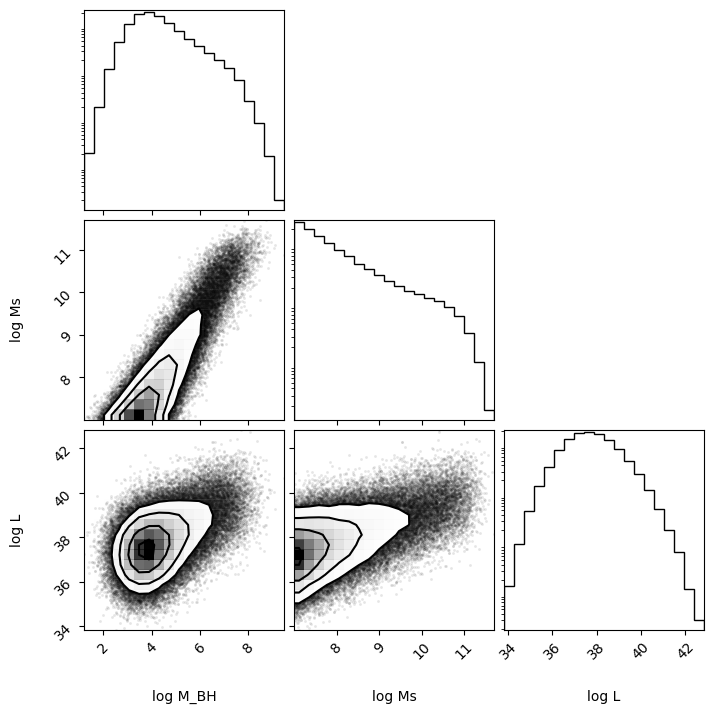

In [33]:
import scipy.stats as st

# grid
dlogm = .1
logms = np.arange(7.0, 12.5, dlogm)
ms = 10**logms
dms = np.diff(ms)

####
logmb = 7.45 + 1.05*(logms - 11)
mb = 10**logmb
dlogmb = np.diff(logmb)[0]

Nsamp = 200
#Nsamp = len(flat_samples)

gsmf = np.zeros([len(logms), Nsamp])
gsmf_blue = np.zeros([len(logms), Nsamp])
gsmf_red = np.zeros([len(logms), Nsamp])

bhmf1_blue = np.zeros([len(logms), Nsamp])
bhmf1_red = np.zeros([len(logms), Nsamp])
bhmf1 = np.zeros([len(logms), Nsamp])

bhlf = np.zeros([len(logms), Nsamp])


# Multiwavelength flat_samples
flat_samples = np.load('../lisa_sam/flatsamples.npy')


for i in range(Nsamp):

    # total BH mass function is dominated by early population
    # GSH20, early-type / E, limits
    alpha_red = np.random.normal(7.89, 0.09, size=1)
    beta_red = np.random.normal(1.33, 0.12, size=1)
    sigma_red = np.random.normal(0.65-0.3, 0.05, size=1)
    logms0_red = np.log10(3*1e10)

    # M_BH ~ M_S^1.33

    # L~ M_S^0.5

    # L ~ (M_BH^1/1.33)^0.5 ~ M_BH^0.8+0.5

    # grid
    logmb_red = alpha_red + beta_red*(logms - logms0_red)
    mb_red = 10**logmb_red
    dmb_red = np.diff(mb_red)

    # BH mass - stellar mass relation
    # RV15 / similar to GSH20, early-type
    alpha_blue = np.random.normal(7.45, 0.08, size=1)
    beta_blue = np.random.normal(1.05, 0.11, size=1)
    sigma_blue = np.random.normal(0.55-0.3, 0.02, size=1) # Assume 10% error on scatter
    logms0_blue = 11

    # grid
    logmb_blue = alpha_blue + beta_blue*(logms - logms0_blue)
    mb_blue = 10**logmb_blue
    dmb_blue = np.diff(mb_blue)
    dlogmb = np.diff(logmb_blue)[0]

    # LX - Ms relation
    alpha_l = 38.1 # -> bol
    beta_l = 0.66 # slope < 1 implies shallower M~M_BH or L \propto M_BH^0.5
    sigma_l = 0.9
    fa = .6
    logms0_l = np.log10(3*1e10)
    
    logl = alpha_l + beta_l*(logms - 10) + 1
    l = 10**logl
    dl = np.diff(l)
    dlogl = np.diff(logl)[0]

    gsmf[:,i] = logGSMF(ms)
    gsmf_blue[:,i] = logGSMF_blue(ms)
    gsmf_red[:,i] = logGSMF_red(ms)

    # Convolve
    #xii = np.exp(flat_samples[i,5])
    #theta2i = flat_samples[i,6]
    #x50i = flat_samples[i,0]
    #focci_xray = 1/(1 + xii * np.exp(-theta2i*(logms - x50i)))**(1/xii)
    xii = 1
    theta2i = 10
    focci_xray = 1/(1 + xii * np.exp(-theta2i*(logms - 9.3)))**(1/xii)

    # Occupation fraction
    s = flat_samples[i]
    xii = np.exp(s[5])
    theta2i = s[6]
    focci = 1/(1 + xii * np.exp(-theta2i*(logms - 10 - s[0])))**(1/xii)

    bhmf1_blue[:,i] = np.array([np.trapz(focci * gsmf_blue[:,i] * st.norm.pdf(logmbi-logms, loc=logmb_blue-logms, scale=sigma_blue)*dlogm) for logmbi in logmb_blue])
    bhmf1_red[:,i] = np.array([np.trapz(focci * gsmf_red[:,i] * st.norm.pdf(logmbi-logms, loc=logmb_red-logms, scale=sigma_red)*dlogm) for logmbi in logmb_red])

    # Interpolate here
    bhmf1[:,i] = np.interp(logmb, logmb_blue, bhmf1_blue[:,i]) + np.interp(logmb, logmb_red, bhmf1_red[:,i])
    
    bhlf[:,i] = np.array([np.trapz(fa * focci * gsmf[:,i] * st.norm.pdf(logli-logms, loc=logl-logms, scale=sigma_l)*dlogm) for logli in logl])

### TODO: Need to interpolate
#bhmf1 = bhmf1_blue + bhmf1_red

# X-ray
V = 4/3*np.pi*(64)**3
N_draw = int(V*np.trapz(np.nanpercentile(gsmf[:-1,:], 50, axis=1)*dlogm))

#### TODO: separate late/early types

# stellar mass
dist_stellar_mass = inv_transform_sampling(np.nanpercentile(gsmf[:-1,:], 50, axis=1), np.log10(ms), N_draw)

dist_bh_mass = alpha_blue + beta_blue*(dist_stellar_mass - logms0_blue) + np.random.normal(0, 0.55, size=len(dist_stellar_mass))

dist_l_bol = alpha_l + beta_l*(dist_stellar_mass - 10) + 1 + np.random.normal(0, 0.9, size=len(dist_stellar_mass))

# Plot the "observed" posterior
observation = torch.tensor([dist_bh_mass, dist_stellar_mass, dist_l_bol]).T
corner.corner(observation.numpy(), labels=['log M_BH', 'log Ms', 'log L'], hist_kwargs={'log':True});

observation_test = observation.ravel()[:8000*3]


In [34]:
samples = posterior.sample((200,), x=observation_test)

Generating samples: 100%|██████████| 2100/2100 [02:11<00:00, 16.02it/s]


/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/sbi/inference/posteriors/mcmc_posterior.py:172: UserWarning: `.log_prob()` is deprecated for methods that can only evaluate the
            log-probability up to a normalizing constant. Use `.potential()` instead.
  warn(
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/sbi/inference/posteriors/mcmc_posterior.py:176: UserWarning: The log-probability is unnormalized!
  warn("The log-probability is unnormalized!")


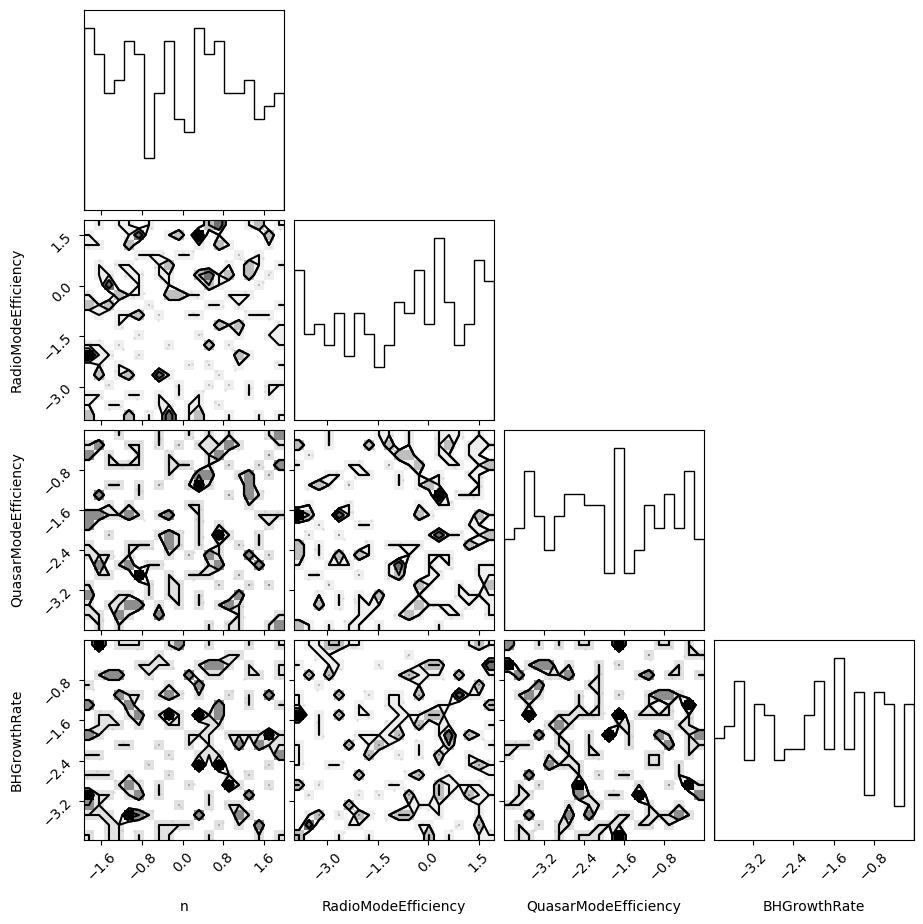

In [35]:
log_probability = posterior.log_prob(samples, x=observation_test)
fig = corner.corner(samples.numpy(), labels=['n', 'RadioModeEfficiency', 'QuasarModeEfficiency', 'BHGrowthRate']);

### Get the distributions for the "best-fit" (calibrated) DarkSage simulation

In [36]:
#thetabest = np.median(samples.numpy(), axis=0)
thetabest = np.array([-.16, 0, 0, 0])
simdist = simulator(thetabest, maxgals=-1) #, rmdir=False) # model_z15.343


99654060
PARS IN: -0.16 1.0 1.0 1.0
Copying from.... /Users/colinburke/research/DarkSage/input/millennium.par
Copying to.... /Users/colinburke/research/DarkSage/input_99654060/millennium.par
Running DarkSage with parfile: /Users/colinburke/research/DarkSage/input_99654060/millennium.par
                   FileNameGalaxies	     model
                          OutputDir	/Users/colinburke/research/DarkSage/output_99654060/
                          FirstFile	         0
                           LastFile	         7
                         NumOutputs	        -1
                           TreeName	 trees_063
                      SimulationDir	/Users/colinburke/research/DarkSage/mini_millennium/treedata
                   FileWithSnapList	/Users/colinburke/research/DarkSage/mini_millennium/millennium.a_list
                     LastSnapShotNr	        63
                              Omega	       0.3
                        OmegaLambda	       0.7
                         BaryonFrac	      0.

In [ ]:
len(simdist)//3

16788

[Text(1, 1e-08, '$\\mathdefault{10^{-8}}$'), Text(1, 1e-07, '$\\mathdefault{10^{-7}}$'), Text(1, 1e-06, '$\\mathdefault{10^{-6}}$'), Text(1, 1e-05, '$\\mathdefault{10^{-5}}$'), Text(1, 0.0001, '$\\mathdefault{10^{-4}}$'), Text(1, 0.001, '$\\mathdefault{10^{-3}}$'), Text(1, 0.01, '$\\mathdefault{10^{-2}}$'), Text(1, 0.1, '$\\mathdefault{10^{-1}}$'), Text(1, 1.0, '$\\mathdefault{10^{0}}$')]
[Text(1, 1e-08, '$\\mathdefault{10^{-8}}$'), Text(1, 1e-07, '$\\mathdefault{10^{-7}}$'), Text(1, 1e-06, '$\\mathdefault{10^{-6}}$'), Text(1, 1e-05, '$\\mathdefault{10^{-5}}$'), Text(1, 0.0001, '$\\mathdefault{10^{-4}}$'), Text(1, 0.001, '$\\mathdefault{10^{-3}}$'), Text(1, 0.01, '$\\mathdefault{10^{-2}}$'), Text(1, 0.1, '$\\mathdefault{10^{-1}}$'), Text(1, 1.0, '$\\mathdefault{10^{0}}$')]
[Text(1, 1e-08, '$\\mathdefault{10^{-8}}$'), Text(1, 1e-07, '$\\mathdefault{10^{-7}}$'), Text(1, 1e-06, '$\\mathdefault{10^{-6}}$'), Text(1, 1e-05, '$\\mathdefault{10^{-5}}$'), Text(1, 0.0001, '$\\mathdefault{10^{-4}

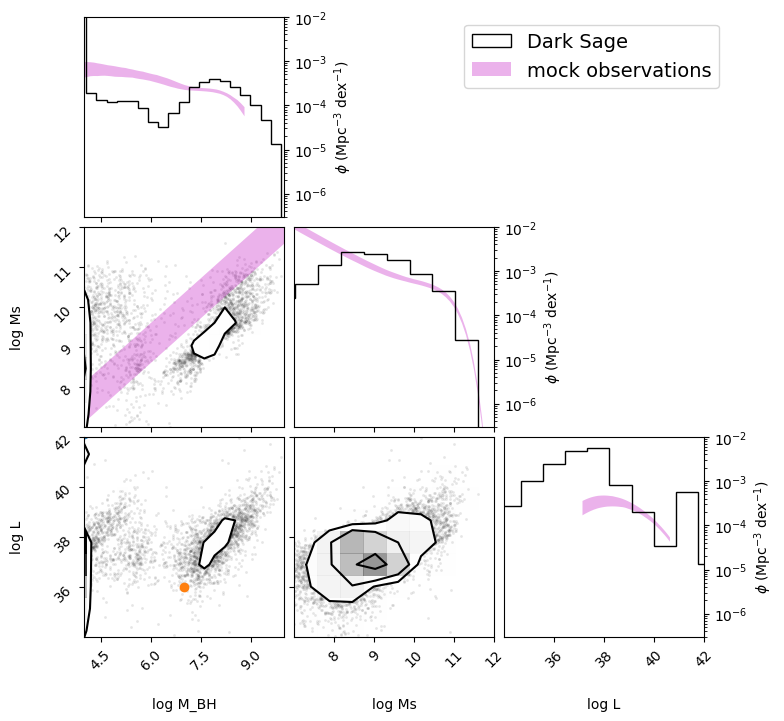

In [ ]:
simdist_unravel = simdist.reshape([3, len(simdist)//3])
V = np.full(len(simdist)//3, 4/3*np.pi*63**3)

from matplotlib.ticker import LogLocator

#ax.xaxis.set_major_locator(LogLocator(numticks=max_n_ticks))

fig = corner.corner(simdist_unravel.numpy().T, labels=['log M_BH', 'log Ms', 'log L'], hist_kwargs={'log':True}, weights=1/V);
axs = np.array(fig.axes).reshape([3,3])

m_eval = np.linspace(2, 9)
logl = np.log10(1.26*1e38) + m_eval
axs[2,0].plot(m_eval, logl, marker='o')
axs[2,0].plot(7, 36, marker='o')

for j, axi in enumerate(axs):
    axs[j,0].set_xlim(4, 10)
    axs[j,1].set_xlim(7, 12)
    axs[j,2].set_xlim(34, 42)
    #

axs[1,0].set_ylim(7, 12)
axs[2,0].set_ylim(34, 42)
axs[2,1].set_ylim(34, 42)

axs[0,0].set_ylim(3e-7, 1e-2)
axs[1,1].set_ylim(3e-7, 1e-2)
axs[2,2].set_ylim(3e-7, 1e-2)



axs[0,0].set_ylabel(r'$\phi$ (Mpc$^{-3}$ dex$^{-1}$)')
axs[0,0].yaxis.set_label_position("right")

axs[1,1].set_ylabel(r'$\phi$ (Mpc$^{-3}$ dex$^{-1}$)')
axs[1,1].yaxis.set_label_position("right")

axs[2,2].set_ylabel(r'$\phi$ (Mpc$^{-3}$ dex$^{-1}$)')
axs[2,2].yaxis.set_label_position("right")

for j, axi in enumerate(axs):
    axi[j].yaxis.tick_right()
    axi[j].yaxis.set_major_locator(LogLocator())

    print(axi[j].get_yticklabels() )

# relations
# logms
axs[1,0].fill_between(logmb_red, logms-0.5, logms+0.5,
                    color="m", alpha=0.3, zorder=-1, lw=0, ls='dotted')

# density functions
axs[1,1].fill_between(np.log10(ms[:-1]), np.percentile(gsmf[:-1], 16, axis=1)*dlogms,
                    np.percentile(gsmf[:-1], 84, axis=1)*dlogms,
                    color="m", alpha=0.3, zorder=-1, lw=0, ls='dotted')

axs[0,0].fill_between(np.log10(mb[:-1]), np.nanpercentile(bhmf1[:-1], 16, axis=1)*dlogmb,
                 np.nanpercentile(bhmf1[:-1], 84, axis=1)*dlogmb,
                 color="m", alpha=0.3, zorder=-1, lw=0, ls='dotted')

axs[2,2].fill_between(np.log10(l[:-1]), np.percentile(bhlf[:-1], 16, axis=1)*dlogl,
                 np.percentile(bhlf[:-1], 84, axis=1)*dlogl,
                 color="m", alpha=0.3, zorder=-1, label='mock observations', lw=0)

axs[0,0].hist([-10, -10], color="k", zorder=-1, label='Dark Sage', lw=1, histtype='step')

##############################################################################

fig.legend(fontsize=14, bbox_to_anchor=(0.48, 0., 0.5, 0.95))
# .get_xticklabels

Text(0.5, 0, 'bh mass')

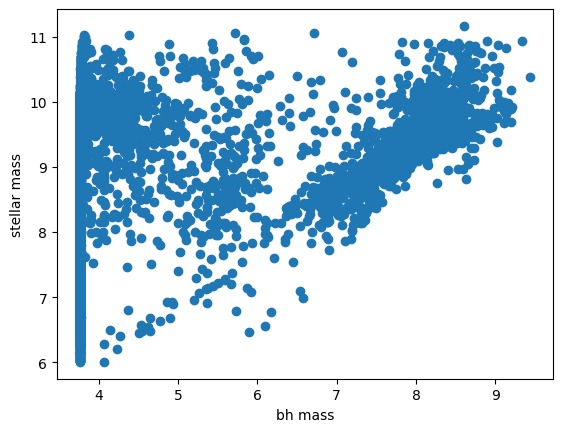

In [ ]:
plt.scatter(simdist_unravel[0,:], simdist_unravel[1,:])
plt.ylabel('stellar mass')
plt.xlabel('bh mass')

# Plot the RV relation
